# Time series clustering based on autocorrelation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess

/Users/willie/.local/share/virtualenvs/time-series-demos-svg3QhUy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1 Generate time series dataset

In [2]:
# Define the ARMA processes. AR params must be negated. See
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
processes = [
    ArmaProcess.from_coeffs([0.0], [0.0]),
    ArmaProcess.from_coeffs([-0.5], [0.0]),
    ArmaProcess.from_coeffs([0.0], [0.9])
]

In [3]:
# Generate the time series.
df = pd.DataFrame()
for i in range(12):
    df[f"TS_{i}"] = processes[i // 4].generate_sample(500)

In [4]:
df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,0.693991,1.243700,0.739551,1.165274,0.693805,-0.121449,-2.128235,0.836156,0.203394,-0.183099,-1.078145,1.664494
1,0.185651,-0.212405,-0.520983,1.064057,0.057938,-1.370595,-0.376992,-0.101086,1.267568,0.183063,0.303673,1.468622
2,-0.631619,-1.503133,0.130986,0.589863,-1.326239,0.966130,0.938041,0.474174,3.259118,0.212453,1.494694,0.857718
3,0.452491,0.830694,-0.622086,2.693432,1.061603,-1.307920,0.650208,-1.793173,2.346237,0.028056,-0.517703,1.272066
4,1.994784,-0.726491,1.142549,-1.297336,-2.841115,0.748864,-1.313691,0.624187,-0.557225,0.834033,-1.341805,-0.384124
5,0.271555,0.128929,0.107278,0.360113,1.982419,-0.752855,0.472138,-0.989065,-1.870253,1.946994,-0.326634,-1.745176
6,-1.253520,0.981422,-0.257177,0.632616,-0.984280,0.445296,0.585633,-0.327353,-0.694241,0.263114,-0.571591,-0.801134
7,0.615633,-0.119418,0.757463,1.600675,1.855688,0.383798,-1.253128,0.390996,0.072436,-0.585426,0.332220,-1.703608
8,-1.117807,1.064011,-0.138745,0.594096,-2.104673,-0.711289,1.381484,-1.074699,-1.069015,-0.339793,1.246414,-1.887700
9,0.835922,0.006854,0.587772,0.080423,0.214237,-0.689083,-0.718181,-0.629242,-0.844160,-1.427985,-0.159199,-0.810084


In [5]:
def plot_df(df, lower, upper, process):
    title = f"TS {lower}-{upper-1}\n{process}"
    df.iloc[:, lower:upper].plot(title=title, figsize=(12, 4), alpha=0.4)
    plt.show()

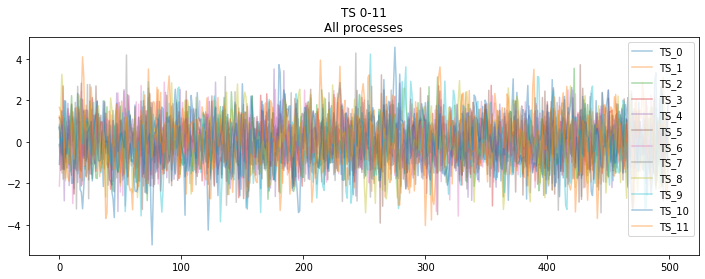

In [6]:
plot_df(df, 0, 12, "All processes")

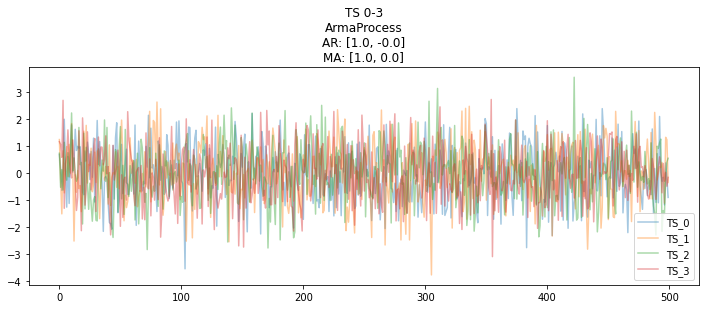

In [7]:
plot_df(df, 0, 4, processes[0])

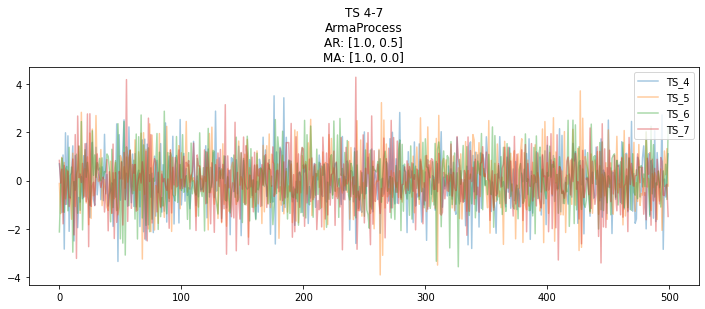

In [8]:
plot_df(df, 4, 8, processes[1])

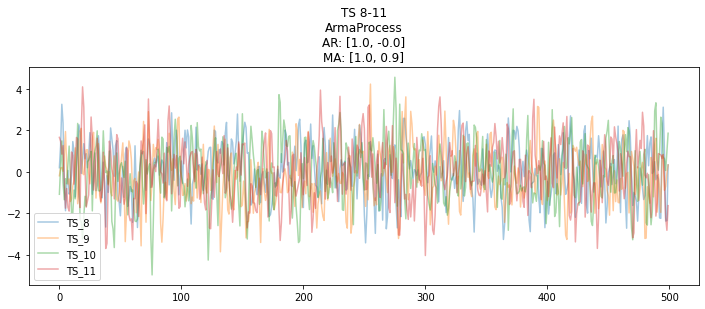

In [9]:
plot_df(df, 8, 12, processes[2])

## 2 Estimate ACFs 

In [10]:
max_lag = 10
lag_arr = np.repeat(max_lag, df.shape[1])
acf_list = list(map(sm.tsa.acf, df.transpose().to_numpy(), lag_arr))
acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns

In [11]:
acf_df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,-0.024026,0.067490,0.052972,-0.022399,-0.454366,-0.532408,-0.446131,-0.525147,0.470695,0.464957,0.520677,0.516286
2,-0.005744,-0.044494,-0.007083,-0.057360,0.181329,0.297812,0.212448,0.301473,-0.054069,-0.062989,0.033733,0.003163
3,-0.040324,0.025554,-0.002430,0.040002,-0.084080,-0.105341,-0.071637,-0.172469,-0.029268,-0.024982,-0.011534,0.010735
4,-0.043785,-0.000035,0.029116,0.034353,0.081204,0.028463,-0.018030,0.115002,0.039969,-0.002875,-0.046848,0.077498
5,0.023516,-0.054885,0.014707,0.034592,-0.051447,0.027118,0.044723,-0.092622,0.047846,-0.033466,-0.001505,0.078847
6,0.042646,-0.018552,-0.029475,-0.005337,0.027247,-0.060129,-0.040212,0.101632,-0.001641,-0.029576,0.043936,0.030446
7,0.015874,0.026391,0.005648,-0.061736,-0.089797,0.123580,0.018849,-0.136208,0.035234,0.009643,0.025104,0.000924
8,-0.001235,-0.135925,0.022010,0.008807,0.060816,-0.113821,-0.071498,0.093264,0.087616,0.065338,-0.041758,0.006652
9,-0.054928,0.008561,0.011520,0.045532,-0.048944,0.068602,-0.028445,-0.108698,0.073724,0.102367,-0.088625,-0.004263


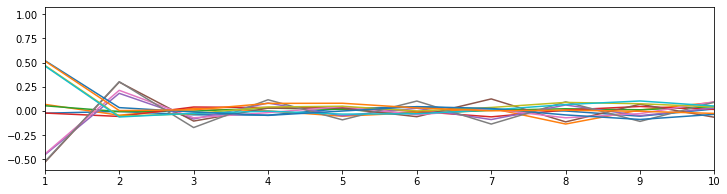

In [12]:
plt.figure(figsize=(12, 3))
plt.xlim((1, max_lag))
plt.plot(acf_df)
plt.show()

## 3 Find clusters

In [13]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

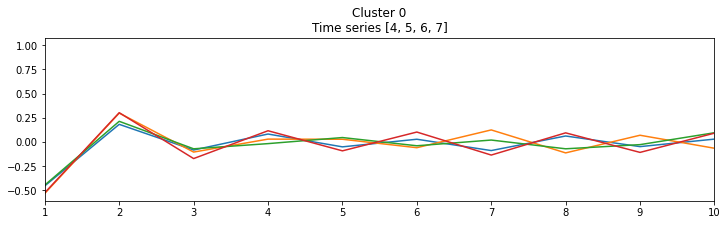

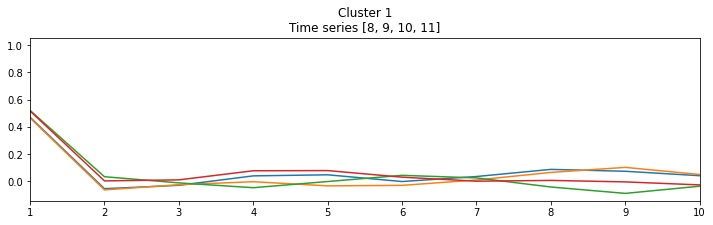

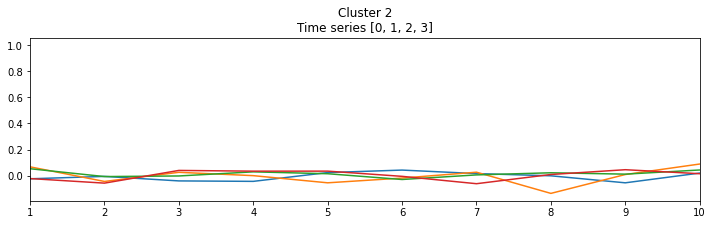

In [14]:
# i ranges over clusters
for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, max_lag))
    
    ts = []
    
    # j ranges over the ACFs
    for j in range(acf_df.shape[1]):
        
        # Plot ACF j in the current cluster i
        if kmeans.labels_[j] == i:
            ts.append(j)
            plt.plot(acf_df.iloc[:, j])
    
    plt.title(f"Cluster {i}\nTime series {ts}")
    plt.show()